# Traditional CNN auf den preprocessed Event-Features
Dieses Notebook nutzt die bereits gespeicherten Daten aus `data/processed` (aus `preprocess_data.py`).
Wir:
- laden `X_train/X_val/X_test` und `y_*` (One-Hot Labels)
- rekonstruieren daraus Bilder mit 2 Kanälen (pos/neg Time-Surface)
- visualisieren ein paar Beispiele
- trainieren ein kleines CNN und testen es auf dem Testset.

In [4]:
# Setup / Imports
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# Damit `models/...` importierbar ist (Notebook liegt in notebooks/traditionalNN/)
sys.path.insert(0, str(Path('..').resolve()))
sys.path.insert(0, str(Path('../..').resolve()))

from models.preprocessing import load_preprocessed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", tf.config.list_physical_devices('GPU'))


2026-01-16 20:00:03.881955: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 20:00:04.101641: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 20:00:04.170621: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-16 20:00:04.170654: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Num GPUs Available:  []


2026-01-16 20:00:05.793132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-16 20:00:05.799454: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-01-16 20:00:05.799508: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2026-01-16 20:00:05.799544: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2026-01-16 20:00:05.799565: W tensorflow/c

In [5]:
# Daten laden
data_dir = Path('../../data/processed')
splits, class_names = load_preprocessed(data_dir)
X_train, y_train = splits['train']
X_val, y_val = splits['val']
X_test, y_test = splits['test']

print('Class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
print('n_features:', n_features)
print('n_classes :', n_classes)

# Wir rekonstruieren ein Bild mit 2 Kanälen aus dem Feature-Vektor.
# In models/preprocessing.py: time_surface -> concat([surface_pos.flatten(), surface_neg.flatten()])
if n_features % 2 != 0:
    raise ValueError(f'Erwarte gerade Feature-Anzahl (pos+neg), bekommen: {n_features}')

hw = n_features // 2
# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

known_shapes = {
    640 * 480: (480, 640),
    64 * 48: (48, 64),
    320 * 240: (240, 320),
}
if hw not in known_shapes:
    raise ValueError(
        f'Unbekannte Bildgröße: hw={hw}. '
        'Passe known_shapes an oder ändere das Preprocessing so, dass width/height bekannt sind.'
    )
H, W = known_shapes[hw]
print('Rekonstruiertes Bildformat:', (H, W, 2))

Loaded train: X=(1652, 614400), y=(1652, 10)
Loaded val: X=(473, 614400), y=(473, 10)
Loaded test: X=(237, 614400), y=(237, 10)
Loaded class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
Class names: ['benjamin', 'christian', 'felix', 'jonas', 'leon', 'mark', 'marvin', 'ohman', 'veronica', 'yannes']
X_train: (1652, 614400) y_train: (1652, 10)
X_val:   (473, 614400) y_val:   (473, 10)
X_test:  (237, 614400) y_test:  (237, 10)
n_features: 614400
n_classes : 10
benjamin: 18 samples
christian: 33 samples
felix: 28 samples
jonas: 28 samples
leon: 30 samples
mark: 422 samples
marvin: 573 samples
ohman: 26 samples
veronica: 33 samples
yannes: 461 samples
Total: 1652 samples
Rekonstruiertes Bildformat: (480, 640, 2)


In [6]:
# Filter to keep only 'yannes', 'marvin', and 'christian' classes
keep_classes = ['yannes', 'marvin', 'mark']
keep_indices = [class_names.index(c) for c in keep_classes]

# Filter training data
train_mask = np.isin(np.argmax(y_train, axis=1), keep_indices)
X_train = X_train[train_mask]
y_train = y_train[train_mask][:, keep_indices]

# Filter validation data
val_mask = np.isin(np.argmax(y_val, axis=1), keep_indices)
X_val = X_val[val_mask]
y_val = y_val[val_mask][:, keep_indices]

# Filter test data
test_mask = np.isin(np.argmax(y_test, axis=1), keep_indices)
X_test = X_test[test_mask]
y_test = y_test[test_mask][:, keep_indices]

# Update class_names and n_classes
class_names = keep_classes
n_classes = len(class_names)

print('Filtered class names:', class_names)
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_val:  ', X_val.shape, 'y_val:  ', y_val.shape)
print('X_test: ', X_test.shape, 'y_test: ', y_test.shape)
print('n_classes:', n_classes)

# Count samples per class
class_counts = np.sum(y_train, axis=0).astype(int)
for i, class_name in enumerate(class_names):
    print(f'{class_name}: {class_counts[i]} samples')
print(f'Total: {np.sum(class_counts)} samples')

Filtered class names: ['yannes', 'marvin', 'mark']
X_train: (1456, 614400) y_train: (1456, 3)
X_val:   (417, 614400) y_val:   (417, 3)
X_test:  (209, 614400) y_test:  (209, 3)
n_classes: 3
yannes: 461 samples
marvin: 573 samples
mark: 422 samples
Total: 1456 samples


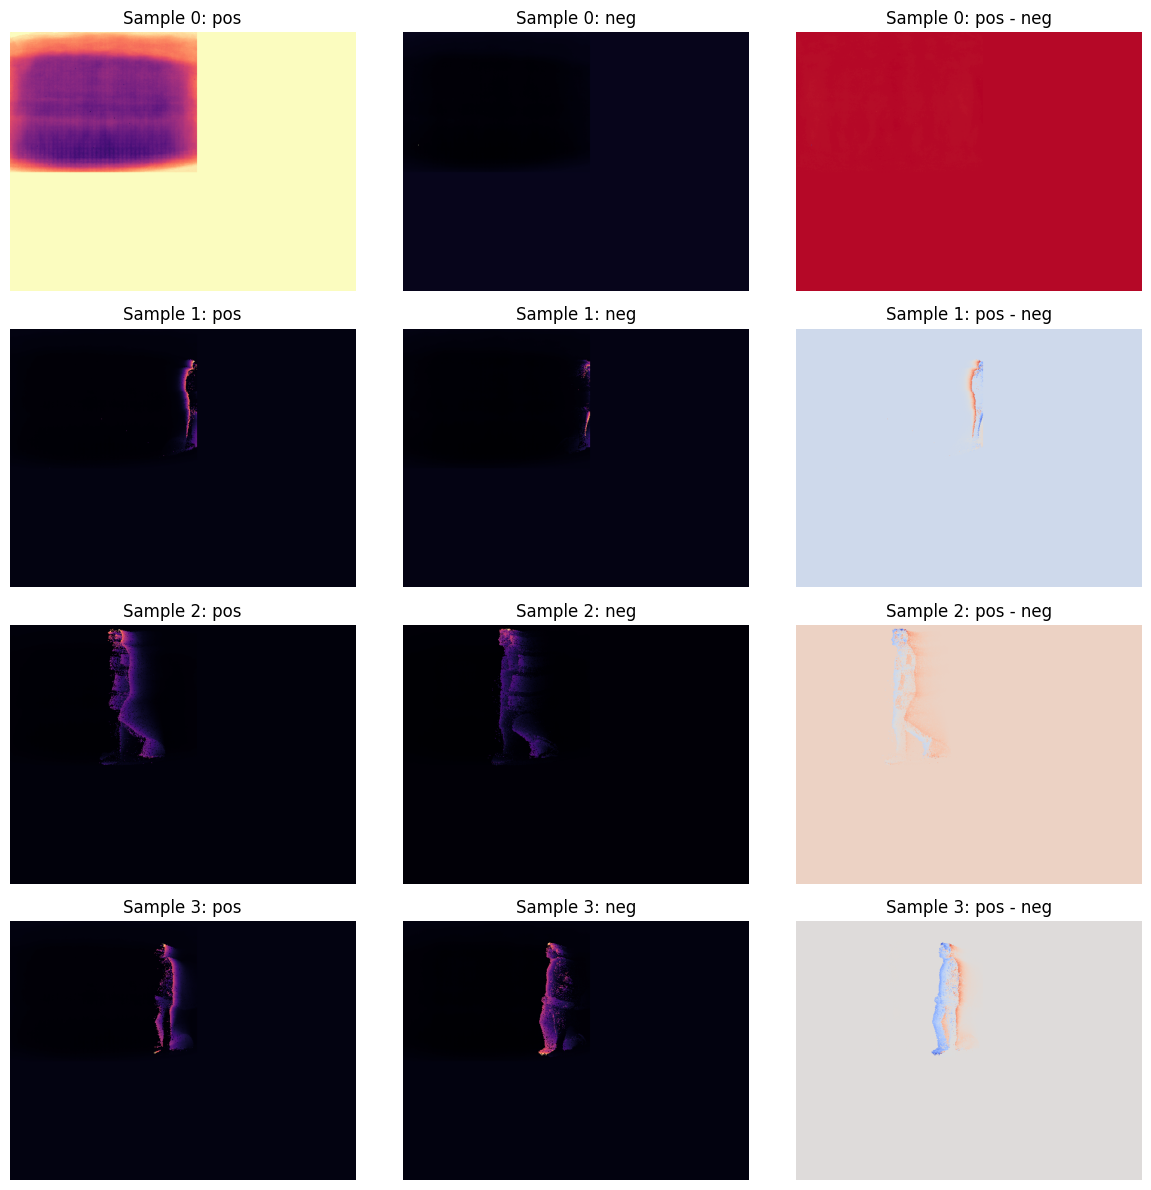

In [7]:
# Kurze Visualisierung (ein paar Samples)
def vector_to_image_np(x_vec: np.ndarray, H: int, W: int) -> np.ndarray:
    x_vec = np.asarray(x_vec)
    hw = H * W
    pos = x_vec[:hw].reshape(H, W)
    neg = x_vec[hw:hw*2].reshape(H, W)
    img = np.stack([pos, neg], axis=-1)  # (H, W, 2)
    return img

n_show = min(4, len(X_train))
fig, axes = plt.subplots(n_show, 3, figsize=(12, 3 * n_show))
if n_show == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(n_show):
    img = vector_to_image_np(X_train[i], H, W)
    pos = img[..., 0]
    neg = img[..., 1]
    diff = pos - neg
    axes[i, 0].imshow(pos, cmap='magma')
    axes[i, 0].set_title(f'Sample {i}: pos')
    axes[i, 1].imshow(neg, cmap='magma')
    axes[i, 1].set_title(f'Sample {i}: neg')
    axes[i, 2].imshow(diff, cmap='coolwarm')
    axes[i, 2].set_title(f'Sample {i}: pos - neg')
    for j in range(3):
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [8]:
# tf.data Pipeline: Vektor -> (H,W,2) ohne große Copies
AUTOTUNE = tf.data.AUTOTUNE

def to_image_tf(x_vec, y):
    x_vec = tf.cast(x_vec, tf.float32)
    hw = H * W
    pos = tf.reshape(x_vec[:hw], (H, W, 1))
    neg = tf.reshape(x_vec[hw:hw*2], (H, W, 1))
    img = tf.concat([pos, neg], axis=-1)  # (H, W, 2)
    y = tf.cast(y, tf.float32)
    return img, y

batch_size = 16
ds_train = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(min(len(X_train), 2000), seed=42, reshuffle_each_iteration=True)
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Sanity-check: ein Batch
x_b, y_b = next(iter(ds_train))
print('Batch X:', x_b.shape, 'Batch y:', y_b.shape)

2026-01-16 20:00:07.908599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Batch X: (16, 480, 640, 2) Batch y: (16, 3)


In [9]:
# ============================================================================
# BASIC TRANSFORMER VIT - VERBESSERT mit CNN-Stem (wie simple_cnn_large)
# ============================================================================

# Höhere Auflösung wie bei simple_cnn_large
target_h, target_w = 192, 256   # erhöht von 96x128
patch = 16                      # größere Patches (192/16=12, 256/16=16 => 192 Tokens)
embed_dim = 256                 # erhöht von 128
num_heads = 8                   # erhöht von 4
mlp_dim = 512                   # erhöht von 256
num_blocks = 4                  # reduziert für weniger Overfitting
dropout = 0.25                  # erhöht von 0.1

def cnn_stem(x):
    """CNN-Stem für lokale Feature-Extraktion vor dem Transformer"""
    # Block 1: lernt lokale Muster
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: komplexere Muster
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    return x

def transformer_block(x):
    # Self-Attention
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout,
    )(y, y)
    x = layers.Add()([x, y])

    # MLP
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(embed_dim)(y)
    y = layers.Dropout(dropout)(y)
    x = layers.Add()([x, y])
    return x

inp = layers.Input(shape=(H, W, 2))
x = layers.Resizing(target_h, target_w)(inp)

# CNN-Stem für bessere lokale Features (Erkenntnisse von simple_cnn_large)
x = cnn_stem(x)
# Nach CNN-Stem: 192/4=48, 256/4=64

# Patch Embedding auf CNN-Features
x = layers.Conv2D(embed_dim, kernel_size=4, strides=4, padding='valid')(x)
# (B, 12, 16, embed_dim) -> (B, N, embed_dim)
x = layers.Reshape((-1, embed_dim))(x)

# Positional Embedding
num_patches = 12 * 16  # 192 Tokens
pos = tf.range(start=0, limit=num_patches, delta=1)
pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(pos)
x = x + pos_emb
x = layers.Dropout(dropout)(x)

for _ in range(num_blocks):
    x = transformer_block(x)

x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output wie bei simple_cnn_large
out = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inp, out, name='basic_transformer_vit')

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=["accuracy"],
)
model.summary()
print(f"\nVerbesserungen: CNN-Stem, 192x256, Dropout=0.25/0.5, 4 Blöcke")

Model: "basic_transformer_vit"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 192, 256, 2)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 192, 256, 32  608         ['resizing[0][0]']               
                                )                                                                 
                                                                              

---
# Verbesserte Transformer-Varianten

Die folgenden Blöcke sind **modular und austauschbar**. Führe jeweils **nur einen** der Model-Blöcke aus, bevor du das Training startest.

## Übersicht:
1. **Konfiguration** - Zentrale Hyperparameter (immer zuerst ausführen)
2. **Data Augmentation** - Verbesserte Datenpipeline
3. **Learning Rate Scheduler** - Warmup + Cosine Decay
4. **Verbesserter Transformer** - Mehr Kapazität, mehr Regularisierung
5. **CLS-Token Transformer** - Mit Classification Token statt Global Pooling
6. **Relative Positional Encoding** - Lernbare relative Positionen
7. **Hybrid CNN-Transformer** - Convolutional Stem + Transformer

## 1. Zentrale Konfiguration
Führe diesen Block **immer zuerst** aus. Hier werden alle Hyperparameter definiert.

In [10]:
# ============================================================================
# ZENTRALE KONFIGURATION - VERBESSERT basierend auf simple_cnn_large Erkenntnissen
# ============================================================================

class Config:
    """Zentrale Hyperparameter-Konfiguration - OPTIMIERT"""
    
    # Bild-Parameter - ERHÖHT wie bei simple_cnn_large
    target_h = 192       # erhöht von 96 (doppelt)
    target_w = 256       # erhöht von 128 (doppelt)
    
    # Patch-Embedding - größere Patches für gleiche Token-Anzahl
    patch_size = 16      # erhöht von 8 (um Token-Anzahl konstant zu halten)
    
    # Transformer Architektur (angepasst für kleine Datensätze)
    embed_dim = 256      # behalten
    num_heads = 8        # behalten
    mlp_dim = 512        # behalten
    num_blocks = 4       # reduziert von 6 (weniger Overfitting)
    
    # Regularisierung (verstärkt wie bei simple_cnn_large)
    dropout = 0.25       # erhöht von 0.2
    attention_dropout = 0.15  # erhöht von 0.1
    mlp_dropout = 0.25   # erhöht von 0.2
    stochastic_depth_rate = 0.15  # erhöht von 0.1
    
    # Training
    batch_size = 16
    epochs = 200
    initial_lr = 1e-4
    weight_decay = 0.01
    label_smoothing = 0.1
    
    # LR Scheduler
    warmup_epochs = 10
    
    # Early Stopping
    patience = 15
    
    @property
    def num_patches(self):
        return (self.target_h // self.patch_size) * (self.target_w // self.patch_size)

cfg = Config()
print(f"Anzahl Patches/Tokens: {cfg.num_patches}")
print(f"Embed Dim: {cfg.embed_dim}, Heads: {cfg.num_heads}, Blocks: {cfg.num_blocks}")
print(f"Dropout: {cfg.dropout}, Attention Dropout: {cfg.attention_dropout}")
print(f"Auflösung: {cfg.target_h}x{cfg.target_w} (wie simple_cnn_large)")

Anzahl Patches/Tokens: 192
Embed Dim: 256, Heads: 8, Blocks: 4
Dropout: 0.25, Attention Dropout: 0.15
Auflösung: 192x256 (wie simple_cnn_large)


## 2. Data Augmentation Pipeline
Verbesserte Datenpipeline mit Augmentation. Ersetze die bestehende `ds_train` damit.

In [11]:
# ============================================================================
# DATA AUGMENTATION - Verbesserte Datenpipeline
# ============================================================================

def random_erasing(img, probability=0.5, sl=0.02, sh=0.4, r1=0.3):
    """Random Erasing / Cutout Augmentation (robust gegen 0>=0 in random_uniform)"""
    if tf.random.uniform([]) > probability:
        return img
    
    img_h = tf.shape(img)[0]
    img_w = tf.shape(img)[1]
    img_area = tf.cast(img_h * img_w, tf.float32)
    
    erase_area = tf.random.uniform([], sl, sh) * img_area
    aspect_ratio = tf.random.uniform([], r1, 1.0 / r1)
    
    erase_h = tf.cast(tf.sqrt(erase_area * aspect_ratio), tf.int32)
    erase_w = tf.cast(tf.sqrt(erase_area / aspect_ratio), tf.int32)
    
    # Clamp: mindestens 1 Pixel, höchstens ganze Bildgröße
    erase_h = tf.clip_by_value(erase_h, 1, img_h)
    erase_w = tf.clip_by_value(erase_w, 1, img_w)
    
    # WICHTIG: maxval muss > minval sein, daher +1 und mind. 1
    max_i = tf.maximum(img_h - erase_h + 1, 1)
    max_j = tf.maximum(img_w - erase_w + 1, 1)
    i = tf.random.uniform([], 0, max_i, dtype=tf.int32)
    j = tf.random.uniform([], 0, max_j, dtype=tf.int32)
    
    padding = [[i, img_h - i - erase_h], [j, img_w - j - erase_w], [0, 0]]
    erase_block = tf.zeros([erase_h, erase_w, 2], dtype=img.dtype)
    erase_mask = tf.pad(erase_block, padding, constant_values=1.0)
    return img * erase_mask

def augment_image(img, y):
    """Wendet zufällige Augmentationen auf das Bild an"""
    img = tf.image.random_flip_left_right(img)
    
    # Random brightness/contrast (sanft für Time-Surface)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    
    # Random zoom/crop (90-100% des Bildes), robust geklemmt
    crop_factor = tf.random.uniform([], 0.9, 1.0)
    img_h = tf.shape(img)[0]
    img_w = tf.shape(img)[1]
    crop_h = tf.cast(tf.cast(img_h, tf.float32) * crop_factor, tf.int32)
    crop_w = tf.cast(tf.cast(img_w, tf.float32) * crop_factor, tf.int32)
    crop_h = tf.clip_by_value(crop_h, 1, img_h)
    crop_w = tf.clip_by_value(crop_w, 1, img_w)
    img = tf.image.random_crop(img, [crop_h, crop_w, 2])
    img = tf.image.resize(img, [img_h, img_w])
    
    # Cutout (probabilistisch innerhalb der Funktion)
    img = random_erasing(img, probability=0.5)
    
    return img, y

def mixup(ds, alpha=0.2):
    """MixUp Augmentation - mischt zwei Samples"""
    def mixup_batch(x1, y1, x2, y2):
        lam = tf.random.uniform([], 0, alpha)
        x = lam * x1 + (1 - lam) * x2
        y = lam * y1 + (1 - lam) * y2
        return x, y
    
    ds2 = ds.shuffle(1000)
    return tf.data.Dataset.zip((ds, ds2)).map(
        lambda xy1, xy2: mixup_batch(xy1[0], xy1[1], xy2[0], xy2[1])
    )

# Augmentierte Training Pipeline
ds_train_aug = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(min(len(X_train), 2000), seed=42, reshuffle_each_iteration=True)
    .map(to_image_tf, num_parallel_calls=AUTOTUNE)
    .map(augment_image, num_parallel_calls=AUTOTUNE)
    .batch(cfg.batch_size)
    .prefetch(AUTOTUNE)
)

# Optional: MixUp aktivieren (auskommentieren falls gewünscht)
# ds_train_aug = mixup(ds_train_aug, alpha=0.2)

print("Augmentierte Training-Pipeline erstellt")
print(f"Batch Size: {cfg.batch_size}")

Augmentierte Training-Pipeline erstellt
Batch Size: 16


## 3. Learning Rate Scheduler
Warmup + Cosine Decay - bewährte Strategie für Transformer-Training.

Steps pro Epoch: 91
Warmup Steps: 910
Total Steps: 18200


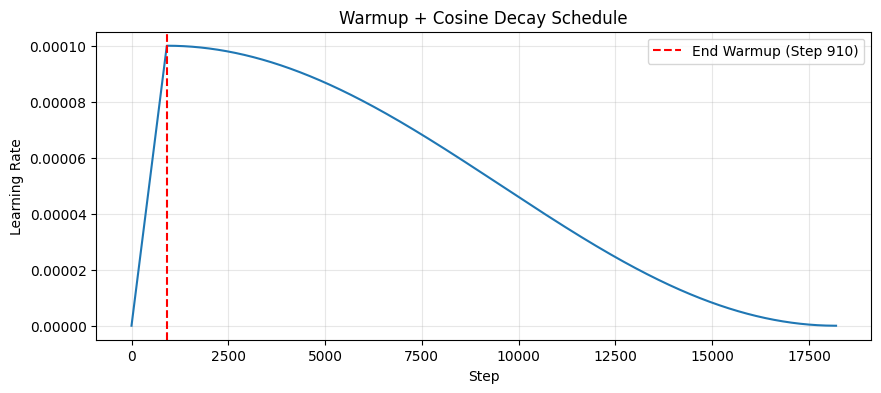

In [12]:
# ============================================================================
# LEARNING RATE SCHEDULER - Warmup + Cosine Decay
# ============================================================================

class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    """
    Learning Rate Schedule mit Warmup und Cosine Decay.
    
    - Warmup: Lineare Steigerung von 0 auf initial_lr über warmup_steps
    - Cosine Decay: Absinken auf 0 über die restlichen Steps
    """
    def __init__(self, initial_lr, warmup_steps, total_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        total_steps = tf.cast(self.total_steps, tf.float32)
        
        # Warmup Phase
        warmup_lr = self.initial_lr * (step / warmup_steps)
        
        # Cosine Decay Phase
        decay_steps = total_steps - warmup_steps
        progress = (step - warmup_steps) / decay_steps
        cosine_decay = 0.5 * (1.0 + tf.cos(np.pi * progress))
        decay_lr = self.initial_lr * cosine_decay
        
        # Wähle basierend auf Step
        return tf.where(step < warmup_steps, warmup_lr, decay_lr)
    
    def get_config(self):
        return {
            'initial_lr': self.initial_lr,
            'warmup_steps': self.warmup_steps,
            'total_steps': self.total_steps,
        }

# Berechne Steps
steps_per_epoch = len(X_train) // cfg.batch_size
total_steps = steps_per_epoch * cfg.epochs
warmup_steps = steps_per_epoch * cfg.warmup_epochs

lr_schedule = WarmupCosineDecay(
    initial_lr=cfg.initial_lr,
    warmup_steps=warmup_steps,
    total_steps=total_steps
)

print(f"Steps pro Epoch: {steps_per_epoch}")
print(f"Warmup Steps: {warmup_steps}")
print(f"Total Steps: {total_steps}")

# Visualisiere LR Schedule
steps = np.arange(total_steps)
lrs = [lr_schedule(s).numpy() for s in steps]

plt.figure(figsize=(10, 4))
plt.plot(steps, lrs)
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Decay Schedule')
plt.axvline(x=warmup_steps, color='r', linestyle='--', label=f'End Warmup (Step {warmup_steps})')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4. Verbesserter Transformer (Option A)
Mehr Kapazität + Stochastic Depth + Attention Dropout. Nutzt Global Average Pooling.

In [13]:
# ============================================================================
# VERBESSERTER TRANSFORMER (Option A) - Mit CNN-Stem und Stochastic Depth
# ============================================================================


class StochasticDepth(layers.Layer):
    """
    Stochastic Depth / Drop Path Layer.
    Zufälliges Überspringen von Residual-Blöcken während des Trainings.
    """

    def __init__(self, drop_prob=0.0, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x, training=None):
        if not training or self.drop_prob == 0.0:
            return x

        keep_prob = 1 - self.drop_prob
        shape = (tf.shape(x)[0],) + (1,) * (len(x.shape) - 1)
        random_tensor = keep_prob + tf.random.uniform(shape, dtype=x.dtype)
        binary_tensor = tf.floor(random_tensor)
        return (x / keep_prob) * binary_tensor

    def get_config(self):
        config = super().get_config()
        config.update({"drop_prob": self.drop_prob})
        return config


def create_improved_transformer():
    """Erstellt einen verbesserten Transformer mit CNN-Stem (wie simple_cnn_large)"""

    # Berechne Drop-Path-Rate pro Block (linear ansteigend)
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) for i in range(cfg.num_blocks)]

    def cnn_stem(x):
        """CNN-Stem für lokale Feature-Extraktion (Erkenntnisse von simple_cnn_large)"""
        # Block 1
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        # Block 2
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x

    def transformer_block_improved(x, drop_rate=0.0):
        # Self-Attention mit Attention Dropout
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])

        # MLP mit erhöhtem Dropout
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation="gelu")(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x

    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)

    # CNN-Stem für lokale Features (NEU!)
    x = cnn_stem(x)
    # Nach CNN-Stem: 192/4=48, 256/4=64

    # Patch Embedding auf CNN-Features (kleinere Patches da schon downsampled)
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding="valid")(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    # (B, 12, 16, embed_dim) -> (B, 192, embed_dim)

    # Positional Embedding
    num_tokens = 12 * 16  # 192 Tokens
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb

    # Dropout nach Embedding
    x = layers.Dropout(cfg.dropout)(x)

    # Transformer Blocks mit Stochastic Depth
    for i in range(cfg.num_blocks):
        x = transformer_block_improved(x, drop_rates[i])

    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation="softmax")(x)

    return keras.Model(inp, out, name="improved_transformer_cnn")


# Modell erstellen
modela = create_improved_transformer()

# Kompilieren mit AdamW und LR Schedule
modela.compile(
    optimizer=keras.optimizers.Adam(weight_decay=cfg.weight_decay),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=["accuracy"],
)

modela.summary()
print(f"\nParameter: {modela.count_params():,}")
print(f"Verbesserungen: CNN-Stem, 192x256, Dropout=0.25/0.5, Stochastic Depth")

Model: "improved_transformer_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_1 (Resizing)          (None, 192, 256, 2)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 192, 256, 32  608         ['resizing_1[0][0]']             
                                )                                                                 
                                                                           

## 5. CLS-Token Transformer (Option B)
Klassischer ViT-Ansatz mit einem speziellen Classification Token anstelle von Global Average Pooling.

In [14]:
# ============================================================================
# CLS-TOKEN TRANSFORMER (Option B) - VERBESSERT mit CNN-Stem
# ============================================================================

class CLSToken(layers.Layer):
    """
    Fügt einen lernbaren CLS-Token am Anfang der Sequenz hinzu.
    Der CLS-Token sammelt globale Information und wird für Klassifikation genutzt.
    """
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
    
    def build(self, input_shape):
        self.cls_token = self.add_weight(
            name='cls_token',
            shape=(1, 1, self.embed_dim),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.embed_dim])
        return tf.concat([cls_tokens, x], axis=1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'embed_dim': self.embed_dim})
        return config

def create_cls_token_transformer():
    """Erstellt einen Transformer mit CLS-Token und CNN-Stem"""
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def cnn_stem(x):
        """CNN-Stem für lokale Feature-Extraktion"""
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x
    
    def transformer_block_v2(x, drop_rate=0.0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # CNN-Stem für lokale Features (NEU!)
    x = cnn_stem(x)
    # Nach CNN-Stem: 192/4=48, 256/4=64
    
    # Patch Embedding auf CNN-Features
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding='valid')(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    
    # CLS Token hinzufügen (vor Positional Embedding!)
    x = CLSToken(cfg.embed_dim)(x)
    
    # Positional Embedding (jetzt +1 für CLS Token)
    num_tokens = 12 * 16 + 1  # 192 + 1 für CLS
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer Blocks
    for i in range(cfg.num_blocks):
        x = transformer_block_v2(x, drop_rates[i])
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # NUR den CLS-Token für Klassifikation nutzen (Index 0)
    cls_output = x[:, 0, :]  # (batch, embed_dim)
    
    x = layers.Dropout(0.5)(cls_output)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='cls_token_transformer_cnn')
"""
# Modell erstellen
modelb = create_cls_token_transformer()

modelb.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

modelb.summary()
print(f"\nParameter: {modelb.count_params():,}")
print("Verbesserungen: CNN-Stem, 192x256, Dropout=0.25/0.5")"""

'\n# Modell erstellen\nmodelb = create_cls_token_transformer()\n\nmodelb.compile(\n    optimizer=keras.optimizers.Adam(\n        weight_decay=cfg.weight_decay\n    ),\n    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),\n    metrics=[\'accuracy\'],\n)\n\nmodelb.summary()\nprint(f"\nParameter: {modelb.count_params():,}")\nprint("Verbesserungen: CNN-Stem, 192x256, Dropout=0.25/0.5")'

## 6. Relative Positional Encoding Transformer (Option C)
Nutzt 2D-relative Positionen statt absolute, was besser für räumliche Zusammenhänge ist.

In [15]:
# ============================================================================
# RELATIVE POSITIONAL ENCODING TRANSFORMER (Option C) - VERBESSERT mit CNN-Stem
# ============================================================================

class RelativePositionalEncoding2D(layers.Layer):
    """
    2D Relative Positional Encoding.
    Lernt relative Positionen zwischen Patches sowohl in x als auch y-Richtung.
    """
    def __init__(self, num_patches_h, num_patches_w, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.num_patches_h = num_patches_h
        self.num_patches_w = num_patches_w
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.relative_position_bias_table_size = (2 * num_patches_h - 1) * (2 * num_patches_w - 1)
    
    def build(self, input_shape):
        self.relative_position_bias_table = self.add_weight(
            name='relative_position_bias_table',
            shape=(self.relative_position_bias_table_size, self.num_heads),
            initializer='truncated_normal',
            trainable=True
        )
        
        coords_h = np.arange(self.num_patches_h)
        coords_w = np.arange(self.num_patches_w)
        coords = np.stack(np.meshgrid(coords_h, coords_w, indexing='ij'))
        coords_flatten = coords.reshape(2, -1)
        
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose(1, 2, 0)
        
        relative_coords[:, :, 0] += self.num_patches_h - 1
        relative_coords[:, :, 1] += self.num_patches_w - 1
        relative_coords[:, :, 0] *= 2 * self.num_patches_w - 1
        
        relative_position_index = relative_coords.sum(-1)
        self.relative_position_index = tf.constant(relative_position_index.flatten(), dtype=tf.int32)
        
        super().build(input_shape)
    
    def call(self, attention_scores):
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, 
            self.relative_position_index
        )
        num_patches = self.num_patches_h * self.num_patches_w
        relative_position_bias = tf.reshape(
            relative_position_bias, 
            [num_patches, num_patches, self.num_heads]
        )
        relative_position_bias = tf.transpose(relative_position_bias, [2, 0, 1])
        return attention_scores + relative_position_bias[None, :, :, :]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'num_patches_h': self.num_patches_h,
            'num_patches_w': self.num_patches_w,
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
        })
        return config

class RelativeAttention(layers.Layer):
    """Multi-Head Attention mit Relative Positional Encoding"""
    def __init__(self, embed_dim, num_heads, num_patches_h, num_patches_w, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.dropout_rate = dropout
        
        self.qkv = layers.Dense(embed_dim * 3, use_bias=True)
        self.proj = layers.Dense(embed_dim)
        self.dropout = layers.Dropout(dropout)
        
        self.rel_pos = RelativePositionalEncoding2D(
            num_patches_h, num_patches_w, embed_dim, num_heads
        )
    
    def call(self, x, training=None):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]
        
        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, [batch_size, seq_len, 3, self.num_heads, self.head_dim])
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = self.rel_pos(attn)
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.dropout(attn, training=training)
        
        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [batch_size, seq_len, self.embed_dim])
        out = self.proj(out)
        
        return out

def create_relative_pos_transformer():
    """Erstellt Transformer mit 2D Relative Positional Encoding und CNN-Stem"""
    
    # Nach CNN-Stem: 192/4=48, 256/4=64, dann /4 für Patches -> 12x16
    num_patches_h = 12
    num_patches_w = 16
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def cnn_stem(x):
        """CNN-Stem für lokale Feature-Extraktion"""
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
        x = layers.MaxPooling2D(2)(x)
        x = layers.Dropout(0.25)(x)
        return x
    
    def transformer_block_rel(x, drop_rate=0.0, block_idx=0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = RelativeAttention(
            cfg.embed_dim, cfg.num_heads, 
            num_patches_h, num_patches_w,
            dropout=cfg.attention_dropout,
            name=f'rel_attn_{block_idx}'
        )(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # CNN-Stem (NEU!)
    x = cnn_stem(x)
    
    # Patch Embedding auf CNN-Features
    x = layers.Conv2D(cfg.embed_dim, kernel_size=4, strides=4, padding='valid')(x)
    x = layers.Reshape((-1, cfg.embed_dim))(x)
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer Blocks mit Relative Positional Attention
    for i in range(cfg.num_blocks):
        x = transformer_block_rel(x, drop_rates[i], block_idx=i)
    
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='relative_pos_transformer_cnn')

# Modell erstellen
modelc = create_relative_pos_transformer()

modelc.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

modelc.summary()
print(f"\nParameter: {modelc.count_params():,}")
print("Verbesserungen: CNN-Stem, 192x256, Dropout=0.25/0.5")

Model: "relative_pos_transformer_cnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_2 (Resizing)          (None, 192, 256, 2)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 192, 256, 32  608         ['resizing_2[0][0]']             
                                )                                                                 
                                                                       

## 7. Hybrid CNN-Transformer (Option D)
Kombiniert einen CNN-Stem für lokale Feature-Extraktion mit Transformer-Blöcken für globale Attention.
Oft die beste Wahl für kleinere Datensätze!

In [16]:
# ============================================================================
# HYBRID CNN-TRANSFORMER (Option D) - VERBESSERT mit simple_cnn_large Architektur
# ============================================================================

def create_hybrid_cnn_transformer():
    """
    Hybrid-Architektur mit verbessertem CNN-Stem (wie simple_cnn_large).
    CNN für lokale Features, Transformer für globale Attention.
    """
    
    drop_rates = [cfg.stochastic_depth_rate * i / max(1, cfg.num_blocks - 1) 
                  for i in range(cfg.num_blocks)]
    
    def transformer_block_hybrid(x, drop_rate=0.0):
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.MultiHeadAttention(
            num_heads=cfg.num_heads,
            key_dim=cfg.embed_dim // cfg.num_heads,
            dropout=cfg.attention_dropout,
        )(y, y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        
        y = layers.LayerNormalization(epsilon=1e-6)(x)
        y = layers.Dense(cfg.mlp_dim, activation='gelu')(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = layers.Dense(cfg.embed_dim)(y)
        y = layers.Dropout(cfg.mlp_dropout)(y)
        y = StochasticDepth(drop_rate)(y)
        x = layers.Add()([x, y])
        return x
    
    # Input
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(cfg.target_h, cfg.target_w)(inp)
    
    # =========== CNN STEM (wie simple_cnn_large) ===========
    # Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 4: 24x32 -> 12x16 (Projection zu embed_dim)
    x = layers.Conv2D(cfg.embed_dim, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(cfg.embed_dim, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # =========== TRANSFORMER ===========
    # Reshape zu Sequenz: (B, 12, 16, embed_dim) -> (B, 192, embed_dim)
    feature_h = cfg.target_h // 16  # nach 4x stride=2 -> 12
    feature_w = cfg.target_w // 16  # -> 16
    num_tokens = feature_h * feature_w  # 192
    
    x = layers.Reshape((num_tokens, cfg.embed_dim))(x)
    
    # Positional Embedding
    pos = tf.range(start=0, limit=num_tokens, delta=1)
    pos_emb = layers.Embedding(input_dim=num_tokens, output_dim=cfg.embed_dim)(pos)
    x = x + pos_emb
    
    x = layers.Dropout(cfg.dropout)(x)
    
    # Transformer Blocks (weniger nötig durch starken CNN-Stem)
    num_transformer_blocks = 2  # Nur 2 Blöcke da CNN schon viel Feature-Arbeit macht
    for i in range(num_transformer_blocks):
        drop_rate = drop_rates[i] if i < len(drop_rates) else drop_rates[-1]
        x = transformer_block_hybrid(x, drop_rate)
    
    # Classification Head
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='hybrid_cnn_transformer')

# Modell erstellen
modeld = create_hybrid_cnn_transformer()

modeld.compile(
    optimizer=keras.optimizers.Adam(
        weight_decay=cfg.weight_decay
    ),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=cfg.label_smoothing),
    metrics=['accuracy'],
)

modeld.summary()
print(f"\nParameter: {modeld.count_params():,}")
print("Verbesserungen: 4-Block CNN-Stem (wie simple_cnn_large), 192x256, Dropout=0.25/0.5")

Model: "hybrid_cnn_transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing_3 (Resizing)          (None, 192, 256, 2)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 192, 256, 32  608         ['resizing_3[0][0]']             
                                )                                                                 
                                                                             

## 8. Einfaches CNN mit größerer Image Size (Option E)
Klassisches CNN ohne Transformer-Komponenten, aber mit größerer Auflösung.

In [17]:
# ============================================================================
# EINFACHES CNN MIT GRÖSSERER IMAGE SIZE (Option E)
# ============================================================================

def create_simple_cnn_large():
    """
    Einfaches CNN mit größerer Auflösung (192x256).
    Keine Transformer-Komponenten, klassische ConvNet-Architektur.
    """
    target_h_large = 192  # doppelt so groß wie bei Transformer
    target_w_large = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_large, target_w_large)(inp)
    
    # Conv Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Conv Block 4: 24x32 -> 12x16
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='simple_cnn_large')

# Modell erstellen
modele = create_simple_cnn_large()

modele.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

modele.summary()
print(f"\nParameter: {modele.count_params():,}")

Model: "simple_cnn_large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 480, 640, 2)]     0         
                                                                 
 resizing_4 (Resizing)       (None, 192, 256, 2)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 192, 256, 32)      608       
                                                                 
 conv2d_24 (Conv2D)          (None, 192, 256, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 96, 128, 32)      0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 96, 128, 32)       0         
                                                  

## 9. LSTM Modell (Option F)
Behandelt das Bild als Sequenz von Zeilen und nutzt LSTM für zeitliche Muster.

In [18]:
# ============================================================================
# LSTM MODELL (Option F) - VERBESSERT mit höherer Auflösung
# ============================================================================

def create_lstm_model():
    """
    LSTM-basiertes Modell mit höherer Auflösung.
    Behandelt das Bild als Sequenz von Zeilen (H Zeitschritte, W*2 Features).
    """
    # Höhere Auflösung wie bei simple_cnn_large
    target_h_lstm = 192
    target_w_lstm = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_lstm, target_w_lstm)(inp)
    
    # Reshape: (B, H, W, 2) -> (B, H, W*2) - jede Zeile ist ein Zeitschritt
    x = layers.Reshape((target_h_lstm, target_w_lstm * 2))(x)
    
    # Bidirectional LSTM mit mehr Units
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.25)(x)  # Dropout wie bei simple_cnn_large
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=False))(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='lstm_model')

# Modell erstellen
"""modelf = create_lstm_model()

modelf.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

modelf.summary()
print(f"\nParameter: {modelf.count_params():,}")
print("Verbesserungen: 192x256, Dropout=0.25/0.5, größerer Dense Layer")"""

'modelf = create_lstm_model()\n\nmodelf.compile(\n    optimizer=keras.optimizers.Adam(1e-3),\n    loss=\'categorical_crossentropy\',\n    metrics=[\'accuracy\'],\n)\n\nmodelf.summary()\nprint(f"\nParameter: {modelf.count_params():,}")\nprint("Verbesserungen: 192x256, Dropout=0.25/0.5, größerer Dense Layer")'

## 10. CNN-LSTM Kombination (Option G)
CNN für Feature-Extraktion, dann LSTM für sequentielle Verarbeitung. Einfach ohne fancy Optimierungen.

In [19]:
# ============================================================================
# CNN-LSTM KOMBINATION (Option G) - VERBESSERT mit simple_cnn_large Architektur
# ============================================================================

def create_cnn_lstm_model():
    """
    CNN-LSTM Kombination mit verbessertem CNN-Stem.
    CNN extrahiert Features wie bei simple_cnn_large, LSTM verarbeitet sie sequentiell.
    """
    # Höhere Auflösung wie bei simple_cnn_large
    target_h_cnn = 192
    target_w_cnn = 256
    
    inp = layers.Input(shape=(H, W, 2))
    x = layers.Resizing(target_h_cnn, target_w_cnn)(inp)
    
    # CNN Feature Extraktion (wie simple_cnn_large)
    # Block 1: 192x256 -> 96x128
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 2: 96x128 -> 48x64
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 3: 48x64 -> 24x32
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Block 4: 24x32 -> 12x16
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)
    
    # Reshape für LSTM: (B, 12, 16, 256) -> (B, 12, 16*256)
    # Jede Zeile des Feature-Maps wird ein Zeitschritt
    feature_h = target_h_cnn // 16  # 12
    feature_w = target_w_cnn // 16  # 16
    x = layers.Reshape((feature_h, feature_w * 256))(x)
    
    # LSTM auf den CNN Features
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=False))(x)
    x = layers.Dropout(0.25)(x)
    
    # Classification Head
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # höheres Dropout vor Output
    out = layers.Dense(n_classes, activation='softmax')(x)
    
    return keras.Model(inp, out, name='cnn_lstm_model')
"""
# Modell erstellen
modelg = create_cnn_lstm_model()

modelg.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

modelg.summary()
print(f"\nParameter: {modelg.count_params():,}")
print("Verbesserungen: 4-Block CNN (wie simple_cnn_large), 192x256, Dropout=0.25/0.5, Bidirectional LSTM")"""

'\n# Modell erstellen\nmodelg = create_cnn_lstm_model()\n\nmodelg.compile(\n    optimizer=keras.optimizers.Adam(1e-3),\n    loss=\'categorical_crossentropy\',\n    metrics=[\'accuracy\'],\n)\n\nmodelg.summary()\nprint(f"\nParameter: {modelg.count_params():,}")\nprint("Verbesserungen: 4-Block CNN (wie simple_cnn_large), 192x256, Dropout=0.25/0.5, Bidirectional LSTM")'

## 8. Verbessertes Training
Führe diesen Block aus, um das ausgewählte Modell zu trainieren.

Run dir: /home/yannes/Documents/neuroAi/notebooks/traditionalNN/runs/model_compare_20260116_200136

Training: simple_cnn_large
Epoch 1/200
91/91 [==============================] - 50s 542ms/step - loss: 1.0965 - accuracy: 0.3901 - val_loss: 1.0904 - val_accuracy: 0.3933
Epoch 2/200
91/91 [==============================] - 50s 545ms/step - loss: 1.0909 - accuracy: 0.3935 - val_loss: 1.0908 - val_accuracy: 0.3933
Epoch 3/200
91/91 [==============================] - 50s 549ms/step - loss: 1.0922 - accuracy: 0.3935 - val_loss: 1.0898 - val_accuracy: 0.3933
Epoch 4/200
91/91 [==============================] - 50s 546ms/step - loss: 1.0913 - accuracy: 0.3935 - val_loss: 1.0915 - val_accuracy: 0.3933
Epoch 5/200
91/91 [==============================] - 50s 548ms/step - loss: 1.0911 - accuracy: 0.3922 - val_loss: 1.0902 - val_accuracy: 0.3933
Epoch 6/200
91/91 [==============================] - 53s 586ms/step - loss: 1.1065 - accuracy: 0.3942 - val_loss: 1.0898 - val_accuracy: 0.3933
Epoch 7/2

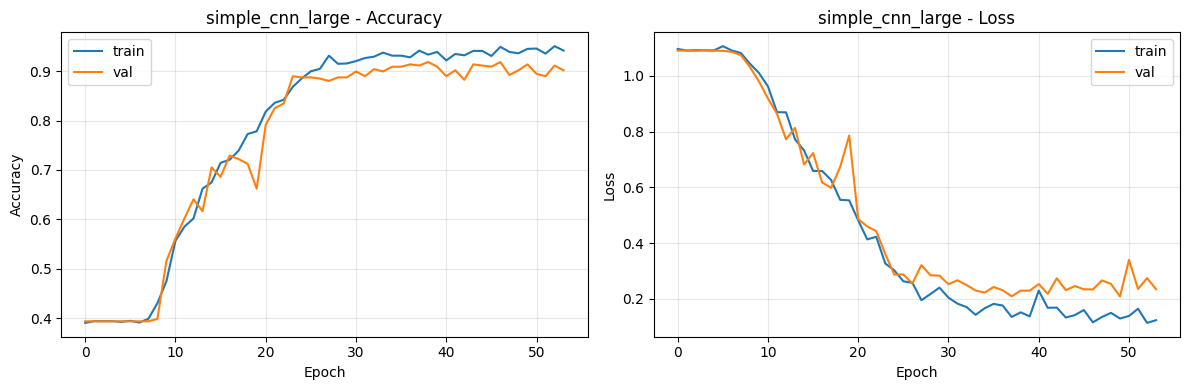

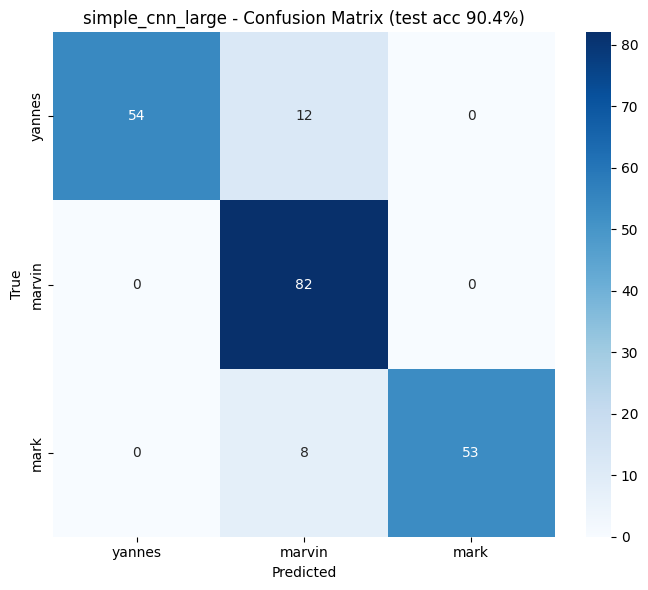


simple_cnn_large
  best val acc : 0.918465256690979
  test acc     : 0.9043062329292297
  test loss    : 0.3222865164279938

Classification report:
               precision    recall  f1-score   support

      yannes     1.0000    0.8182    0.9000        66
      marvin     0.8039    1.0000    0.8913        82
        mark     1.0000    0.8689    0.9298        61

    accuracy                         0.9043       209
   macro avg     0.9346    0.8957    0.9070       209
weighted avg     0.9231    0.9043    0.9053       209


Training: relative_pos_transformer_cnn
Epoch 1/200
91/91 [==============================] - 60s 620ms/step - loss: 1.5702 - accuracy: 0.3427 - val_loss: 1.2219 - val_accuracy: 0.3933
Epoch 2/200
91/91 [==============================] - 61s 667ms/step - loss: 1.2144 - accuracy: 0.3613 - val_loss: 1.0845 - val_accuracy: 0.3933
Epoch 3/200
91/91 [==============================] - 60s 664ms/step - loss: 1.1518 - accuracy: 0.3551 - val_loss: 1.1067 - val_accuracy: 0.42

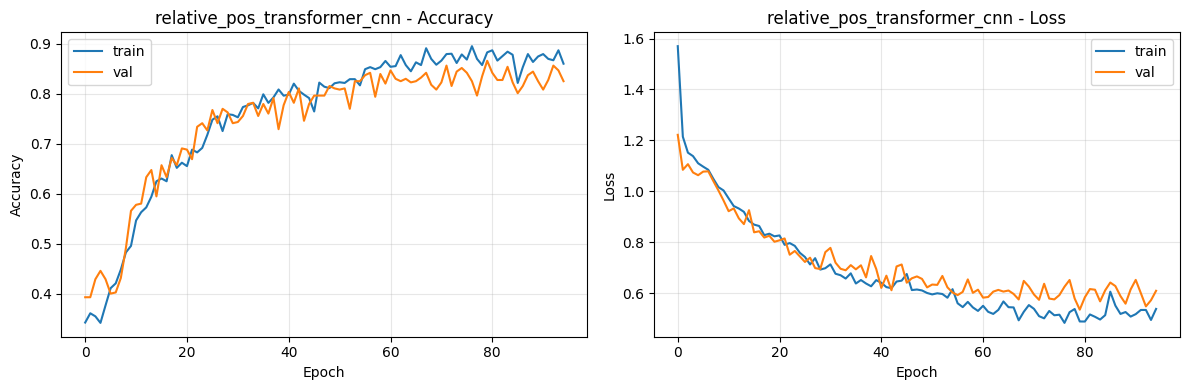

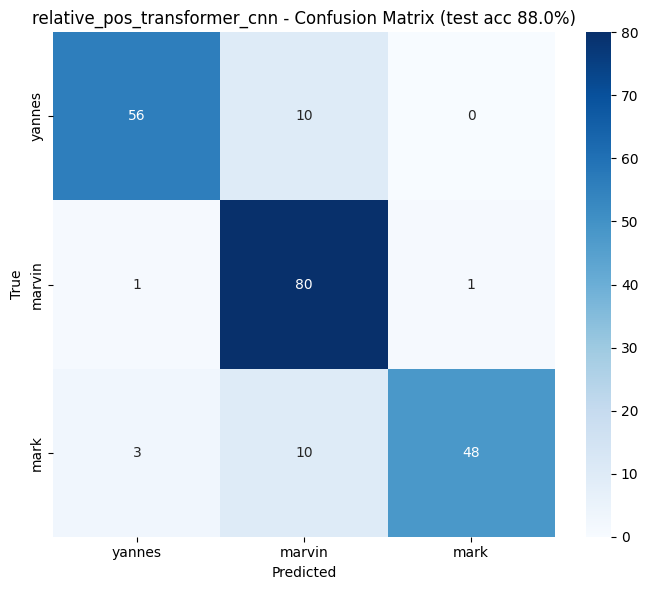


relative_pos_transformer_cnn
  best val acc : 0.8657074570655823
  test acc     : 0.880382776260376
  test loss    : 0.4916130304336548

Classification report:
               precision    recall  f1-score   support

      yannes     0.9333    0.8485    0.8889        66
      marvin     0.8000    0.9756    0.8791        82
        mark     0.9796    0.7869    0.8727        61

    accuracy                         0.8804       209
   macro avg     0.9043    0.8703    0.8802       209
weighted avg     0.8945    0.8804    0.8803       209


Training: hybrid_cnn_transformer
Epoch 1/200
91/91 [==============================] - 69s 735ms/step - loss: 1.3999 - accuracy: 0.3626 - val_loss: 1.1017 - val_accuracy: 0.3165
Epoch 2/200
91/91 [==============================] - 62s 679ms/step - loss: 1.1636 - accuracy: 0.3434 - val_loss: 1.1431 - val_accuracy: 0.3933
Epoch 3/200
91/91 [==============================] - 67s 735ms/step - loss: 1.1350 - accuracy: 0.3441 - val_loss: 1.1236 - val_accuracy

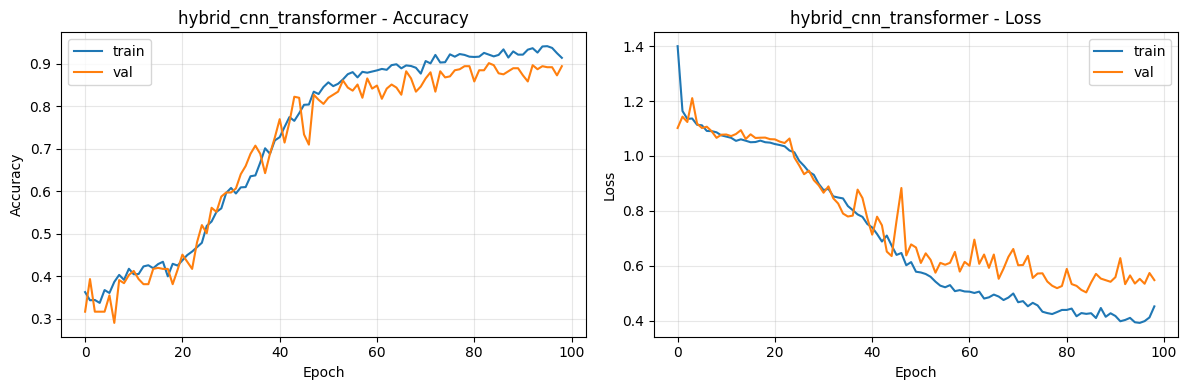

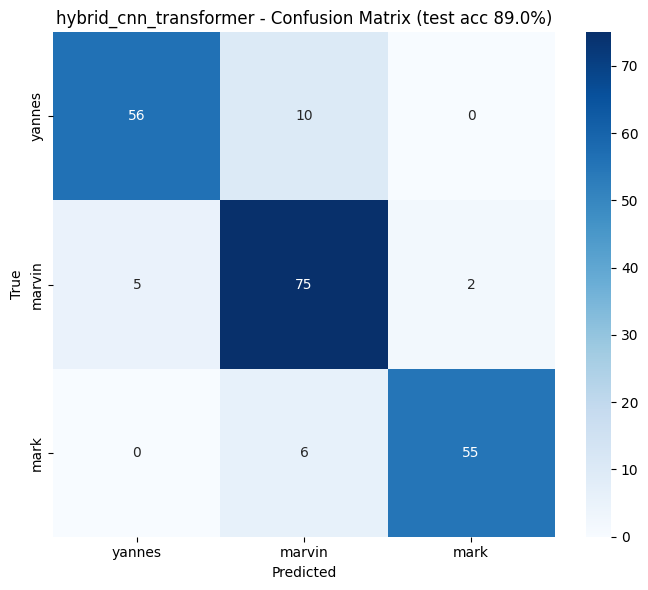


hybrid_cnn_transformer
  best val acc : 0.9016786813735962
  test acc     : 0.8899521827697754
  test loss    : 0.5017191171646118

Classification report:
               precision    recall  f1-score   support

      yannes     0.9180    0.8485    0.8819        66
      marvin     0.8242    0.9146    0.8671        82
        mark     0.9649    0.9016    0.9322        61

    accuracy                         0.8900       209
   macro avg     0.9024    0.8883    0.8937       209
weighted avg     0.8949    0.8900    0.8908       209


Training: basic_transformer_vit
Epoch 1/200
91/91 [==============================] - 57s 588ms/step - loss: 1.5042 - accuracy: 0.3674 - val_loss: 1.1535 - val_accuracy: 0.3189
Epoch 2/200
91/91 [==============================] - 57s 626ms/step - loss: 1.2023 - accuracy: 0.3565 - val_loss: 1.1382 - val_accuracy: 0.3477
Epoch 3/200
91/91 [==============================] - 53s 582ms/step - loss: 1.1608 - accuracy: 0.3441 - val_loss: 1.0975 - val_accuracy: 0.39

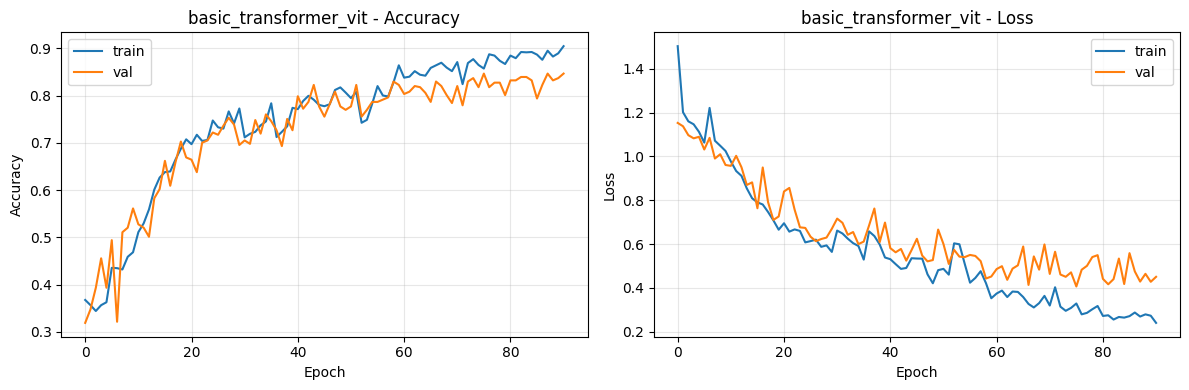

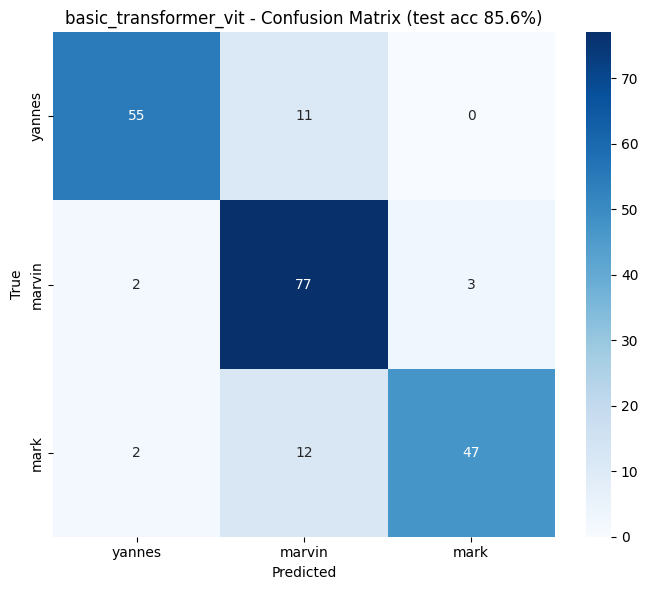


basic_transformer_vit
  best val acc : 0.8465228080749512
  test acc     : 0.8564593195915222
  test loss    : 0.3287782371044159

Classification report:
               precision    recall  f1-score   support

      yannes     0.9322    0.8333    0.8800        66
      marvin     0.7700    0.9390    0.8462        82
        mark     0.9400    0.7705    0.8468        61

    accuracy                         0.8565       209
   macro avg     0.8807    0.8476    0.8577       209
weighted avg     0.8708    0.8565    0.8570       209


Training: improved_transformer_cnn
Epoch 1/200
91/91 [==============================] - 53s 540ms/step - loss: 1.5132 - accuracy: 0.3352 - val_loss: 1.0986 - val_accuracy: 0.3861
Epoch 2/200
91/91 [==============================] - 48s 533ms/step - loss: 1.1962 - accuracy: 0.3503 - val_loss: 1.1312 - val_accuracy: 0.4005
Epoch 3/200
91/91 [==============================] - 48s 531ms/step - loss: 1.1605 - accuracy: 0.3324 - val_loss: 1.1012 - val_accuracy: 0.

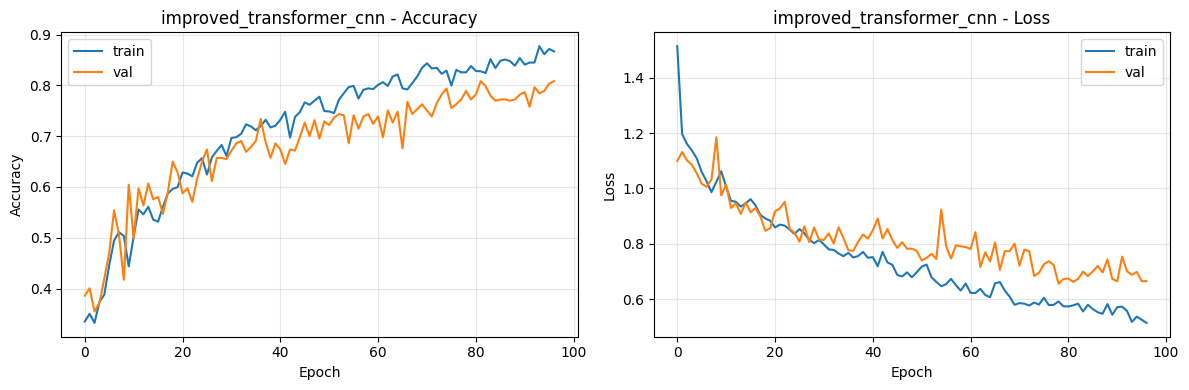

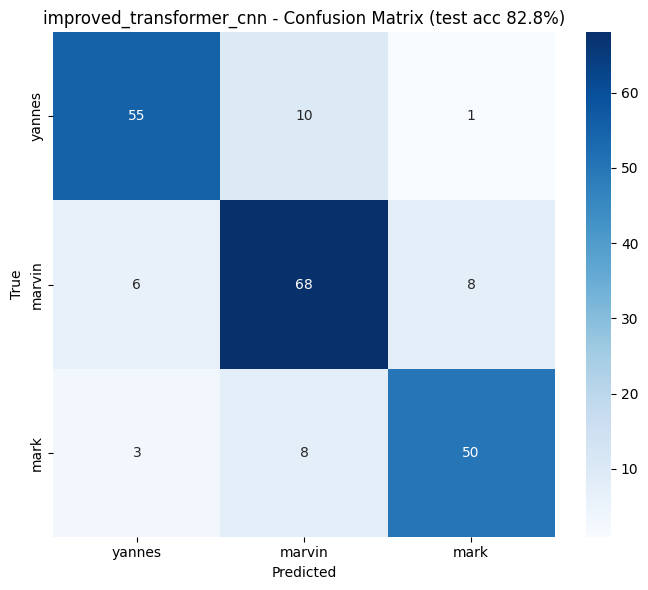


improved_transformer_cnn
  best val acc : 0.8081534504890442
  test acc     : 0.8277512192726135
  test loss    : 0.5900437235832214

Classification report:
               precision    recall  f1-score   support

      yannes     0.8594    0.8333    0.8462        66
      marvin     0.7907    0.8293    0.8095        82
        mark     0.8475    0.8197    0.8333        61

    accuracy                         0.8278       209
   macro avg     0.8325    0.8274    0.8297       209
weighted avg     0.8290    0.8278    0.8280       209


Saved results: results.json
Models saved: ['simple_cnn_large.keras', 'relative_pos_transformer_cnn.keras', 'hybrid_cnn_transformer.keras', 'basic_transformer_vit.keras', 'improved_transformer_cnn.keras']


In [24]:
# ============================================================================
# MULTI-MODEL TRAINING + EVALUATION + SAVING (Option A–G nacheinander)
# ============================================================================

from pathlib import Path
from datetime import datetime
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Dataset wählen
USE_AUGMENTATION = False
train_dataset = ds_train_aug if (USE_AUGMENTATION and 'ds_train_aug' in globals()) else ds_train

# Run-Ordner
run_dir = Path('./runs') / f"model_compare_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
run_dir.mkdir(parents=True, exist_ok=True)
print('Run dir:', run_dir.resolve())

# Model-Builder sammeln (nur wenn die entsprechenden Zellen vorher ausgeführt wurden)



results = {}
trained_models = {}  # optional: im RAM behalten
models = [modele,   modelc, modeld,  model, modela,  ] #modelb,modelf, modelg
for mdl in models:
    print('\n' + '='*80)
    print('Training:', mdl.name)
    print('='*80)

    tf.keras.backend.clear_session()

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=cfg.patience,
            restore_best_weights=True,
            verbose=1,
        ),
    ]

    history = mdl.fit(
        train_dataset,
        validation_data=ds_val,
        epochs=cfg.epochs,
        callbacks=callbacks,
        verbose=1,
    )

    # Speichern (best weights sind durch EarlyStopping restored)
    model_path = run_dir / f'{mdl.name}.keras'
    mdl.save(model_path)
    print('Saved:', model_path.name)

    # Test-Evaluation
    eval_out = mdl.evaluate(ds_test, verbose=1, return_dict=True)
    test_loss = eval_out['loss']
    test_acc = eval_out['accuracy']
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')
    # Predictions für Confusion Matrix
    y_true_all, y_pred_all = [], []
    for batch_x, batch_y in ds_test:
        probs = mdl.predict(batch_x, verbose=0)
        y_true_all.extend(tf.argmax(batch_y, axis=1).numpy())
        y_pred_all.extend(tf.argmax(probs, axis=1).numpy())
    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    cm = confusion_matrix(y_true_all, y_pred_all)
    report = classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4)

    # Plots: Training curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].plot(history.history.get('accuracy', []), label='train')
    axes[0].plot(history.history.get('val_accuracy', []), label='val')
    axes[0].set_title(f'{mdl.name} - Accuracy')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Accuracy')
    axes[0].grid(alpha=0.3); axes[0].legend()

    axes[1].plot(history.history.get('loss', []), label='train')
    axes[1].plot(history.history.get('val_loss', []), label='val')
    axes[1].set_title(f'{mdl.name} - Loss')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Loss')
    axes[1].grid(alpha=0.3); axes[1].legend()
    plt.tight_layout()
    plt.show()
    fig.savefig(run_dir / f'{mdl.name}_curves.png', dpi=150, bbox_inches='tight')
    plt.close(fig)

    # Plot: Confusion Matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.title(f'{mdl.name} - Confusion Matrix (test acc {test_acc*100:.1f}%)')
    plt.tight_layout()
    plt.show()
    plt.savefig(run_dir / f'{mdl.name}_confusion.png', dpi=150, bbox_inches='tight')
    plt.close()

    # Persist summary artifacts
    (run_dir / f'{mdl.name}_classification_report.txt').write_text(report)
    hist_path = run_dir / f'{mdl.name}_history.json'
    hist_path.write_text(json.dumps(history.history, indent=2))

    best_val_acc = float(np.max(history.history.get('val_accuracy', [np.nan])))
    best_val_loss = float(np.min(history.history.get('val_loss', [np.nan])))

    results[mdl.name] = {
        'model_path': str(model_path),
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'best_val_accuracy': best_val_acc,
        'best_val_loss': best_val_loss,
        'epochs_ran': int(len(history.history.get('loss', []))),
    }

    print('\n' + mdl.name)
    print('  best val acc :', best_val_acc)
    print('  test acc     :', float(test_acc))
    print('  test loss    :', float(test_loss))
    print('\nClassification report:\n', report)

    trained_models[mdl.name] = mdl  # falls du später noch im Notebook weiterarbeiten willst

# Save overall results
(run_dir / 'results.json').write_text(json.dumps(results, indent=2))
print('\nSaved results:', (run_dir / 'results.json').name)
print('Models saved:', [Path(v['model_path']).name for v in results.values()])

=== Model Comparison ===
simple_cnn_large | test_acc=0.9043 | test_loss=0.3223 | best_val_acc=0.9185 | epochs=54
relative_pos_transformer_cnn | test_acc=0.8804 | test_loss=0.4916 | best_val_acc=0.8657 | epochs=95
hybrid_cnn_transformer | test_acc=0.8900 | test_loss=0.5017 | best_val_acc=0.9017 | epochs=99
basic_transformer_vit | test_acc=0.8565 | test_loss=0.3288 | best_val_acc=0.8465 | epochs=91
improved_transformer_cnn | test_acc=0.8278 | test_loss=0.5900 | best_val_acc=0.8082 | epochs=97


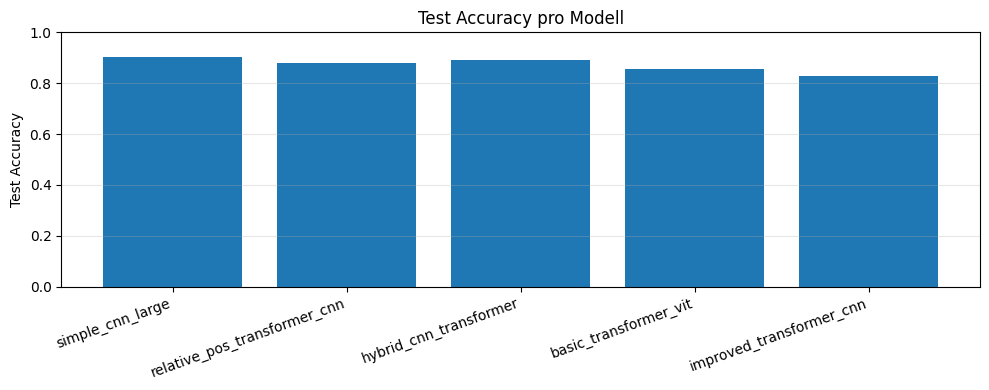

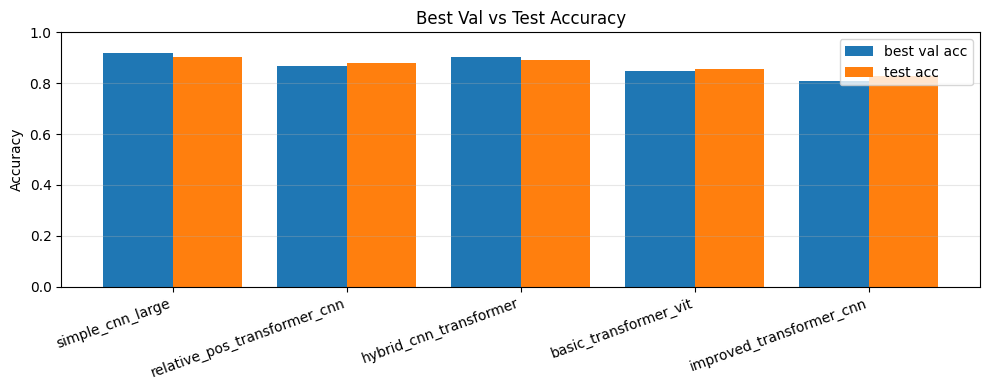

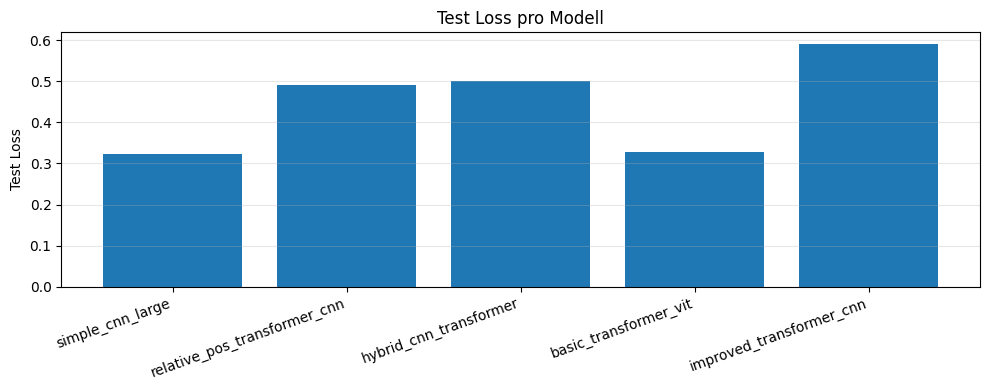


Tipp: Alle Artefakte (Modelle, Kurven, Confusion Matrices, Reports) liegen im run_dir aus Zelle 19.


In [25]:
# ============================================================================
# VERGLEICH (alle Modelle) - Tabelle + Plots
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt

if 'results' not in globals() or not results:
    raise RuntimeError('Keine results gefunden. Führe zuerst Zelle 19 (Multi-Model Training) aus.')

names = list(results.keys())
test_acc = np.array([results[n]['test_accuracy'] for n in names], dtype=float)
test_loss = np.array([results[n]['test_loss'] for n in names], dtype=float)
best_val_acc = np.array([results[n]['best_val_accuracy'] for n in names], dtype=float)
epochs_ran = np.array([results[n]['epochs_ran'] for n in names], dtype=int)

print('=== Model Comparison ===')
for n in names:
    r = results[n]
    print(f"{n:>14} | test_acc={r['test_accuracy']:.4f} | test_loss={r['test_loss']:.4f} | best_val_acc={r['best_val_accuracy']:.4f} | epochs={r['epochs_ran']}")

# Bar: Test Accuracy
plt.figure(figsize=(10, 4))
plt.bar(names, test_acc)
plt.ylim(0, 1.0)
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy pro Modell')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

# Bar: Best Val Accuracy vs Test Accuracy
x = np.arange(len(names))
w = 0.4
plt.figure(figsize=(10, 4))
plt.bar(x - w/2, best_val_acc, width=w, label='best val acc')
plt.bar(x + w/2, test_acc, width=w, label='test acc')
plt.ylim(0, 1.0)
plt.xticks(x, names, rotation=20, ha='right')
plt.ylabel('Accuracy')
plt.title('Best Val vs Test Accuracy')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Bar: Test Loss
plt.figure(figsize=(10, 4))
plt.bar(names, test_loss)
plt.ylabel('Test Loss')
plt.title('Test Loss pro Modell')
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

print('\nTipp: Alle Artefakte (Modelle, Kurven, Confusion Matrices, Reports) liegen im run_dir aus Zelle 19.')

In [ ]:
target_h, target_w = 96, 128   # muss durch patch teilbar sein
patch = 8                      # 96/8=12, 128/8=16 => 192 Tokens
embed_dim = 128
num_heads = 4
mlp_dim = 256
num_blocks = 4
dropout = 0.1

def transformer_block(x):
    # Self-Attention
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim // num_heads,
        dropout=dropout,
    )(y, y)
    x = layers.Add()([x, y])

    # MLP
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(mlp_dim, activation='gelu')(y)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(embed_dim)(y)
    x = layers.Add()([x, y])
    return x

inp = layers.Input(shape=(H, W, 2))
x = layers.Resizing(target_h, target_w)(inp)

# Patch Embedding (Conv2D mit stride=patch entspricht "patchify + linear proj")
x = layers.Conv2D(embed_dim, kernel_size=patch, strides=patch, padding='valid')(x)
# (B, H/patch, W/patch, embed_dim) -> (B, N, embed_dim)
x = layers.Reshape((-1, embed_dim))(x)

# Positional Embedding
num_patches = (target_h // patch) * (target_w // patch)
pos = tf.range(start=0, limit=num_patches, delta=1)
pos_emb = layers.Embedding(input_dim=num_patches, output_dim=embed_dim)(pos)
x = x + pos_emb

for _ in range(num_blocks):
    x = transformer_block(x)

x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout)(x)
out = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inp, out)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 640, 2  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 96, 128, 2)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 12, 16, 128)  16512       ['resizing[0][0]']               
                                                                                                  
 reshape (Reshape)              (None, 192, 128)     0           ['conv2d[0][0]']             

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
]

history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=100,
    #callbacks=callbacks,
)

Epoch 1/100
52/52 [==============================] - 8s 93ms/step - loss: 1.3100 - accuracy: 0.3834 - val_loss: 1.1950 - val_accuracy: 0.2521
Epoch 2/100
52/52 [==============================] - 4s 84ms/step - loss: 1.1701 - accuracy: 0.3748 - val_loss: 1.1262 - val_accuracy: 0.3419
Epoch 3/100
52/52 [==============================] - 4s 83ms/step - loss: 1.1403 - accuracy: 0.3675 - val_loss: 1.1356 - val_accuracy: 0.4060
Epoch 4/100
52/52 [==============================] - 5s 88ms/step - loss: 1.1236 - accuracy: 0.3748 - val_loss: 1.1143 - val_accuracy: 0.3504
Epoch 5/100
52/52 [==============================] - 5s 88ms/step - loss: 1.1136 - accuracy: 0.3895 - val_loss: 1.0768 - val_accuracy: 0.3932
Epoch 6/100
52/52 [==============================] - 5s 95ms/step - loss: 1.1001 - accuracy: 0.3980 - val_loss: 1.0838 - val_accuracy: 0.4060
Epoch 7/100
52/52 [==============================] - 5s 97ms/step - loss: 1.1083 - accuracy: 0.3968 - val_loss: 1.0759 - val_accuracy: 0.4017
Epoch 

8/8 [==============================] - 0s 33ms/step - loss: 1.7482 - accuracy: 0.5847

Keras metrics: {'loss': 1.7482235431671143, 'accuracy': 0.5847457647323608}

Extra metrics:
  accuracy           : 0.5847
  balanced_accuracy  : 0.5889
  precision/recall/f1 (macro)   : 0.6097 / 0.5889 / 0.5822
  precision/recall/f1 (weighted): 0.6053 / 0.5847 / 0.5775
  top2_acc (manual)   : 0.8559

Classification Report:
              precision    recall  f1-score   support

      yannes     0.6957    0.4000    0.5079        40
      marvin     0.5333    0.6667    0.5926        48
        mark     0.6000    0.7000    0.6462        30

    accuracy                         0.5847       118
   macro avg     0.6097    0.5889    0.5822       118
weighted avg     0.6053    0.5847    0.5775       118



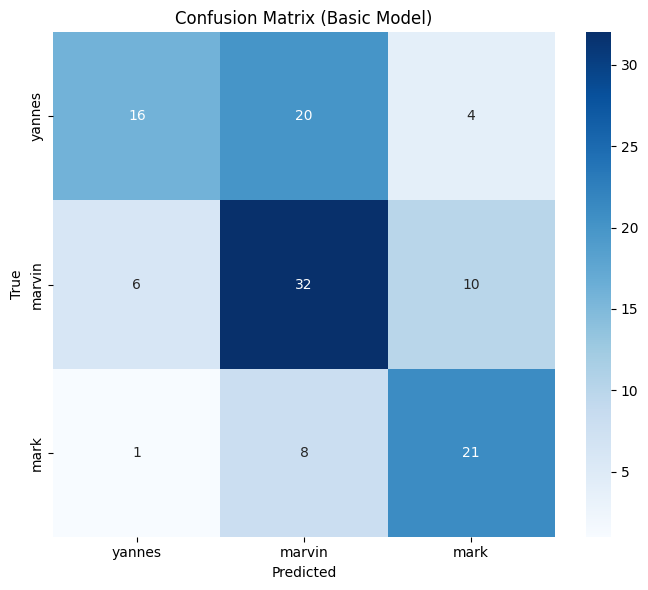

In [ ]:
# Testing / Evaluation am Testset (erweitert)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix, classification_report,
)

# Keras evaluate (zeigt die compile()-Metriken)
eval_out = model.evaluate(ds_test, verbose=1, return_dict=True)
print('\nKeras metrics:', eval_out)

# Predictions sammeln
y_true, y_pred = [], []
probs_all = []
for batch_x, batch_y in ds_test:
    probs = model.predict(batch_x, verbose=0)
    probs_all.append(probs)
    y_true.extend(tf.argmax(batch_y, axis=1).numpy())
    y_pred.extend(np.argmax(probs, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs_all = np.concatenate(probs_all, axis=0)

# Extra-Metriken (sklearn)
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

p_macro, r_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)
p_w, r_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

# Top-2 Accuracy aus Probabilities
top2 = np.mean([yt in np.argsort(probs_all[i])[-2:] for i, yt in enumerate(y_true)])

print('\nExtra metrics:')
print(f'  accuracy           : {acc:.4f}')
print(f'  balanced_accuracy  : {bacc:.4f}')
print(f'  precision/recall/f1 (macro)   : {p_macro:.4f} / {r_macro:.4f} / {f1_macro:.4f}')
print(f'  precision/recall/f1 (weighted): {p_w:.4f} / {r_w:.4f} / {f1_w:.4f}')
print(f'  top2_acc (manual)   : {top2:.4f}')

print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Basic Model)')
plt.tight_layout()
plt.show()

# (Optional) ein paar Vorhersagen anzeigen


In [ ]:
n_pred = 5
for batch_x, batch_y in ds_test.take(1):
    probs = model.predict(batch_x, verbose=0)
    y_true = tf.argmax(batch_y, axis=1).numpy()
    y_pred = tf.argmax(probs, axis=1).numpy()
    # Confidence (probability) of the predicted class for each sample
    confidences = probs[np.arange(probs.shape[0]), y_pred]
    for i in range(min(n_pred, len(y_true))):
        print(f'Sample {i}: true={class_names[y_true[i]]}, pred={class_names[y_pred[i]]}, conf={confidences[i]:.3f}')

Sample 0: true=yannes, pred=yannes, conf=0.480
Sample 1: true=yannes, pred=yannes, conf=1.000
Sample 2: true=mark, pred=mark, conf=0.998
Sample 3: true=marvin, pred=marvin, conf=0.646
Sample 4: true=marvin, pred=marvin, conf=0.889
